In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision.transforms import Normalize

import utils.config as config

/home/coffeetumbler/anaconda3/envs/sr_trans/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load trained model.
model = torch.load('logs/X2/20230730_221828/model/model.pt', map_location='cuda')
model.eval()
model.load_state_dict(torch.load('logs/X2/20230730_221828/state_dict/state_dict_step_284000.pt', map_location='cpu'))
# model.load_state_dict(torch.load('logs/iru/20230705_193228_x2/state_dict_best.pt', map_location='cpu'))

<All keys matched successfully>

In [3]:
# Save model for LAM analysis.
torch.save(model, 'LAM_Demo/ModelZoo/models/EWIRE_x2_w16.pt')

In [4]:
# Normalizing operator
normalize_img = Normalize(config.IMG_NORM_MEAN, config.IMG_NORM_STD)

In [5]:
# Load an image.
lr_img = cv2.imread('/mnt/d/ubuntu/datasets/sr_benchmark/Data/valid_ipt/Set5/LR_bicubic/X2/babyx2.png', cv2.IMREAD_COLOR).copy()
hr_img = cv2.imread('/mnt/d/ubuntu/datasets/sr_benchmark/Data/valid_ipt/Set5/HR/baby.png', cv2.IMREAD_COLOR).copy()

lr_input = normalize_img(torch.from_numpy(lr_img.transpose(2,0,1)).float() / 255).unsqueeze(0)

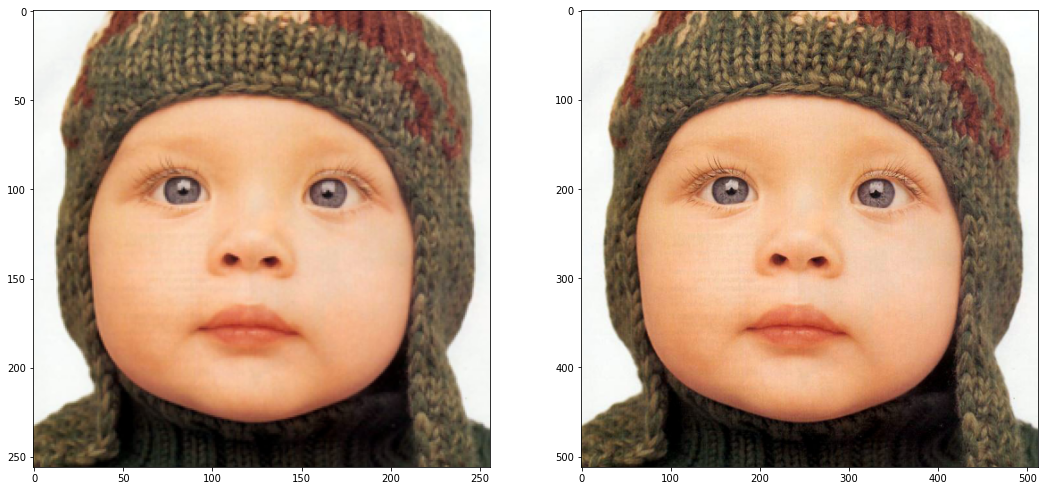

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(18, 18))
axs[0].imshow(lr_img[:,:,::-1])
axs[1].imshow(hr_img[:,:,::-1])
fig.show()

In [7]:
# Extract feature maps. - DWIRE & EWIRE
load_mask = False

_, _, H, W = lr_input.shape

# Set padding options.
H_pad = ((H - 1) // model.window_size + 1) * model.window_size
W_pad = ((W - 1) // model.window_size + 1) * model.window_size

h_pad = H_pad - H
w_pad = W_pad - W

# Pad boundaries.
pad_img = torch.nn.functional.pad(lr_input, (0, w_pad, 0, h_pad), mode='reflect')

with torch.no_grad():
    map_init = model.initial_feature_mapping(pad_img.to('cuda'))

    encoded = [map_init.permute(0, 2, 3, 1)]
    for i in range(model.n_block):
        x = model.block_norm_layers[i](encoded[i])
        x = getattr(model, 'block_{}'.format(i+1))(x, load_mask)
        encoded.append(encoded[i] + model.feature_addition_modules[i](x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1))
    del(encoded[0])

    output = torch.cat((map_init, encoded[-1].permute(0, 3, 1, 2)), dim=1)
    for layer in model.reconstruction_module:
        output = layer(output)

output = output[..., :H*model.sr_upscale, :W*model.sr_upscale]

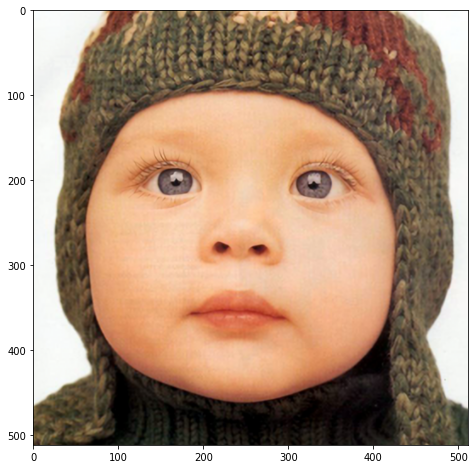

In [8]:
# Show output.
rec_img = torch.Tensor(config.IMG_NORM_MEAN)[:, None, None] + output[0].cpu() * torch.Tensor(config.IMG_NORM_STD)[:, None, None]
rec_img = (rec_img * 255).numpy().astype(int).transpose(1,2,0)

plt.figure(figsize=(8,8))
plt.imshow(rec_img[:, :, ::-1])
plt.show()

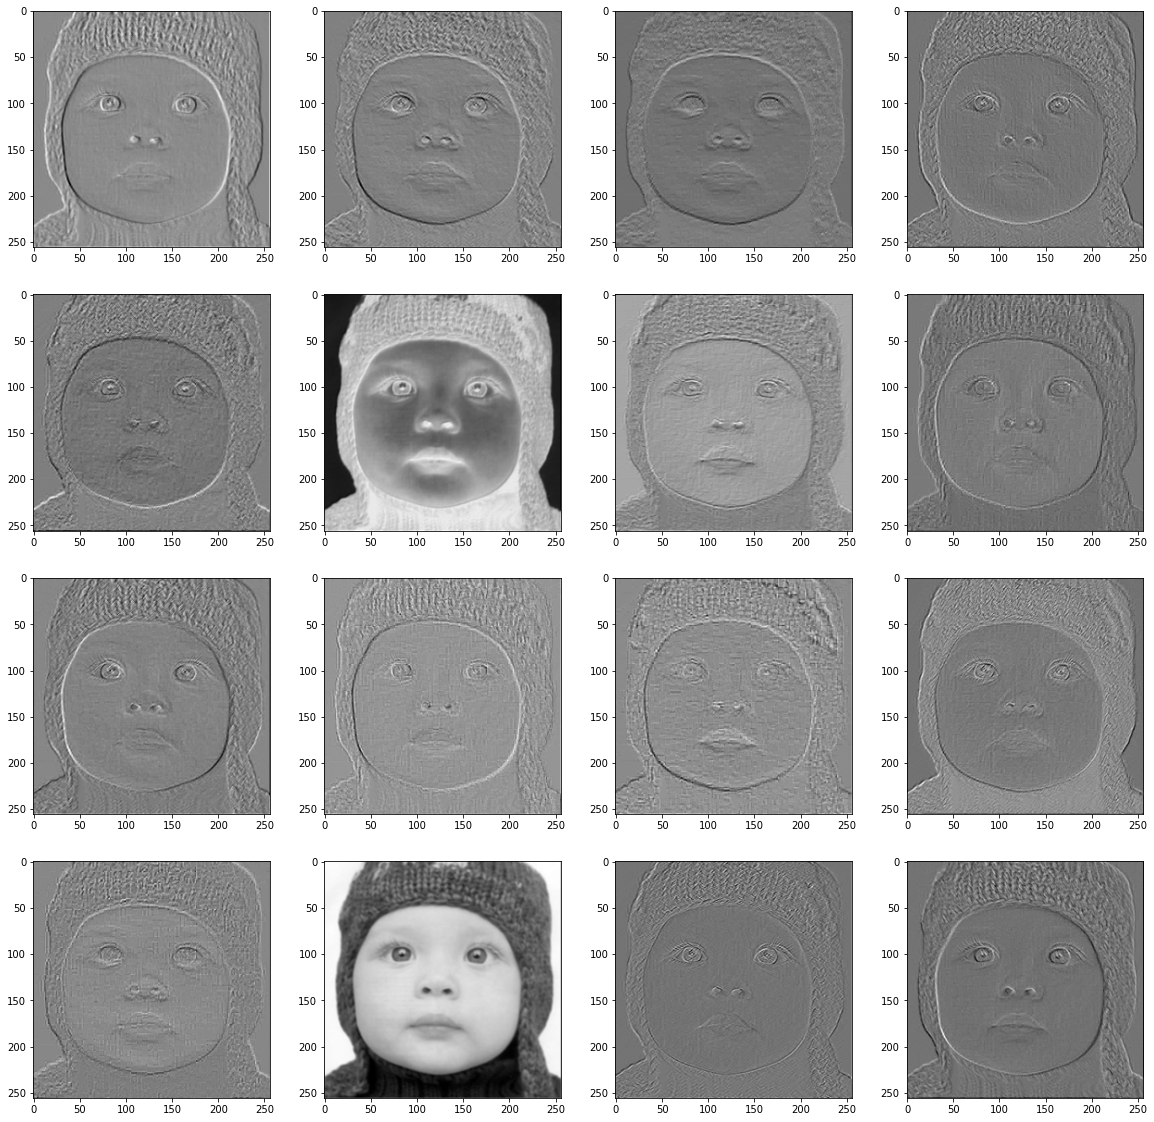

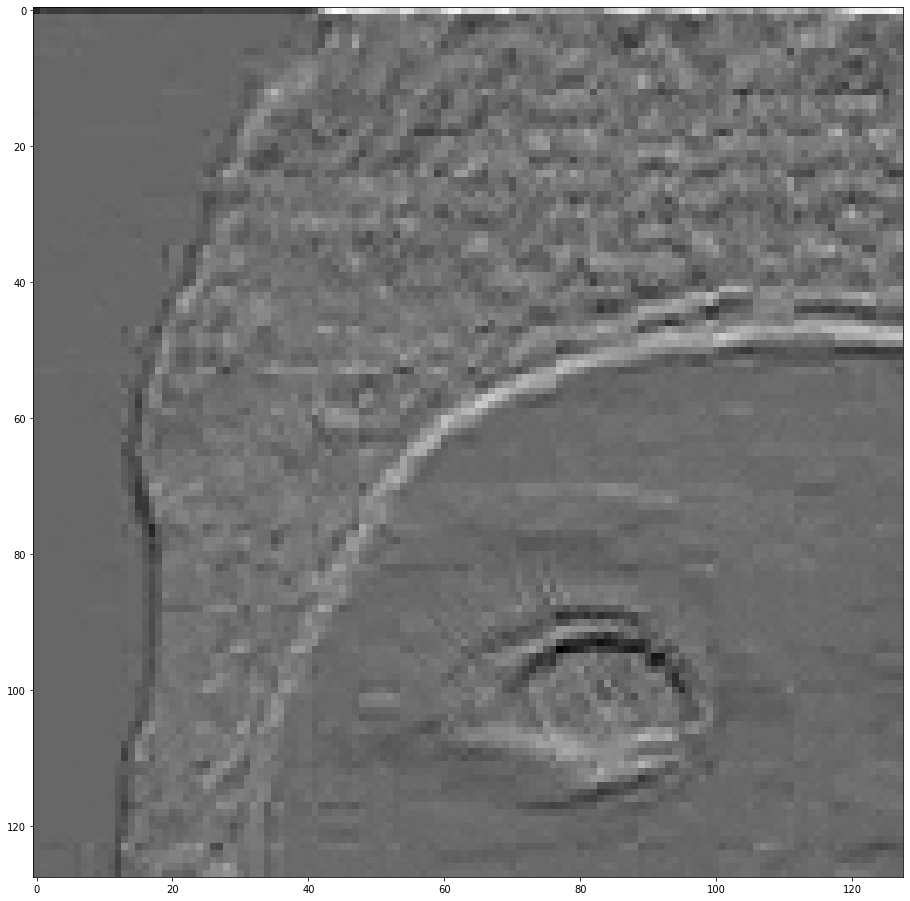

In [9]:
# Visualize feature maps. - init map
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
maps = map_init[0].cpu().numpy()

for i in range(16):
    axs[i//4, i%4].imshow(maps[i], cmap='gray')
    
plt.figure(figsize=(16,16))
plt.imshow(map_init[0, 2, :128, :128].cpu().numpy(), cmap='gray')
plt.show()

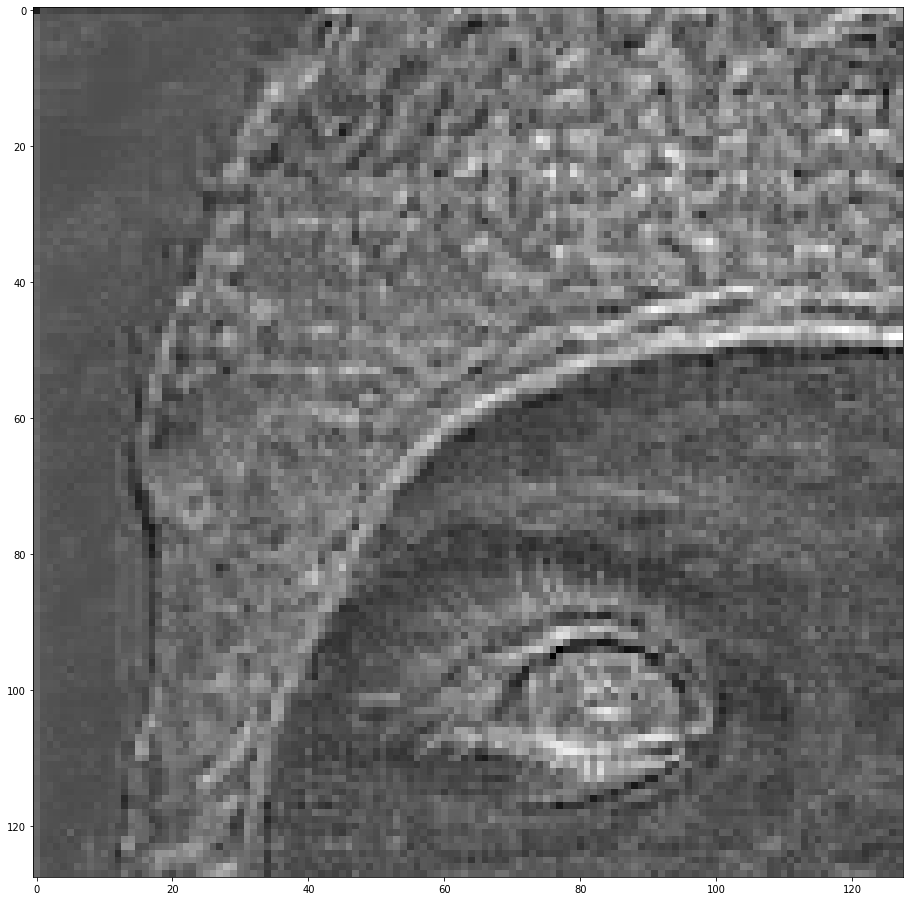

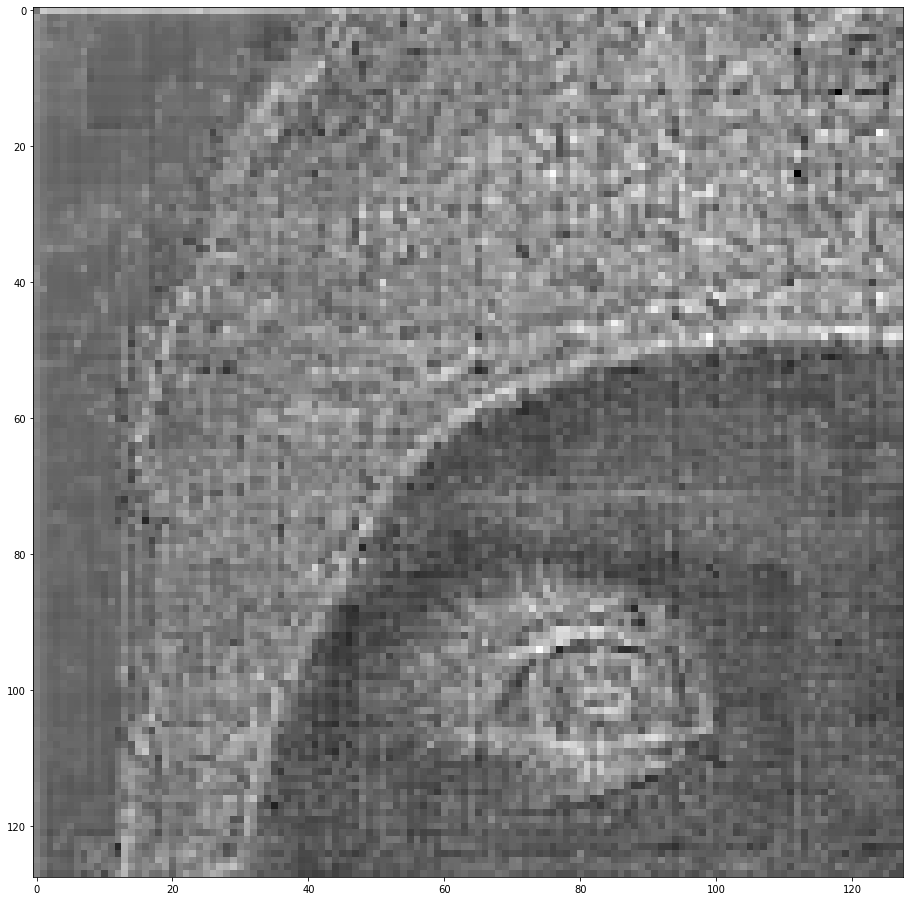

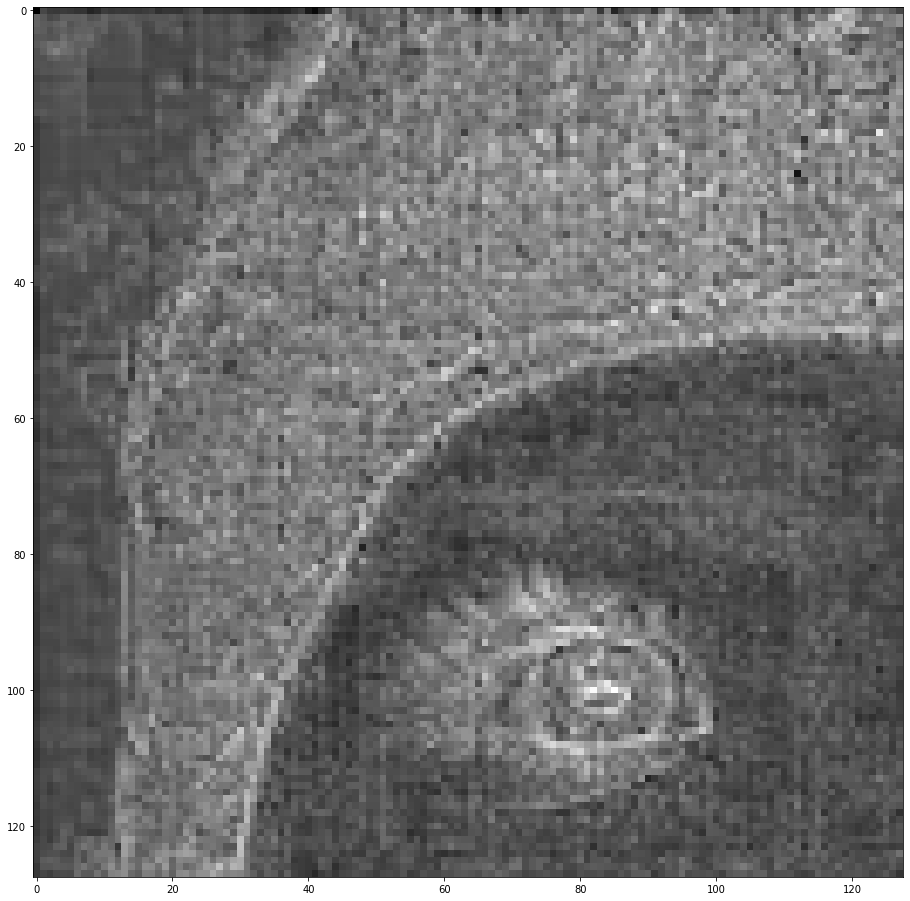

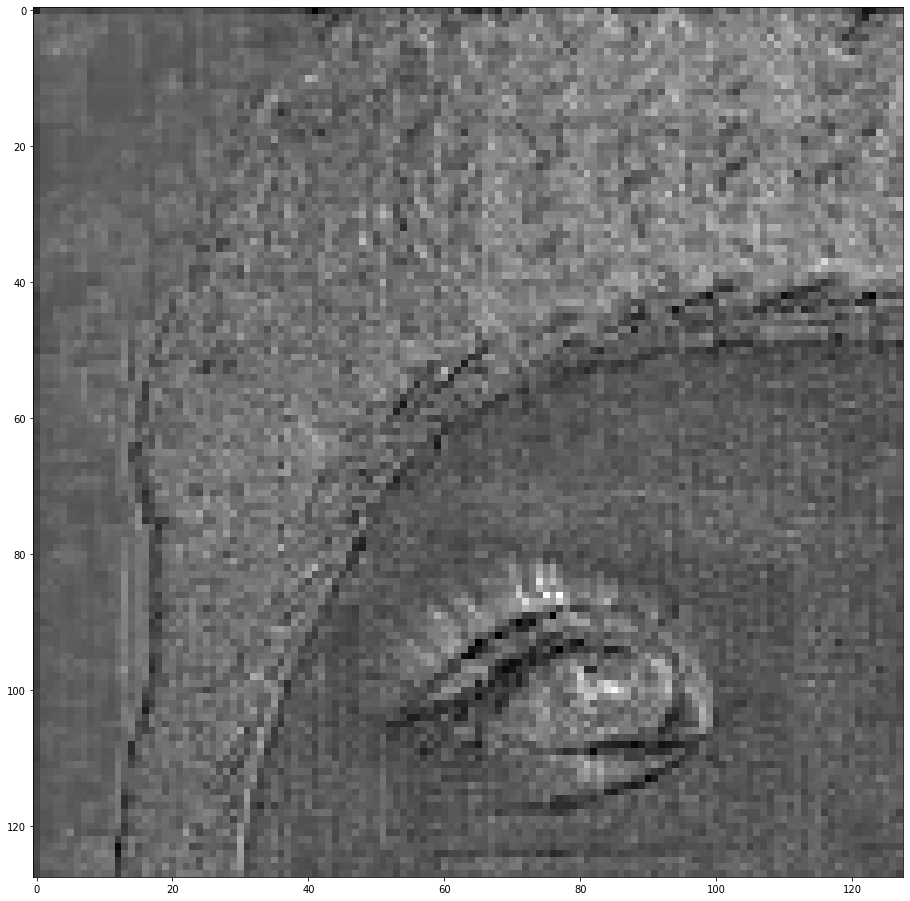

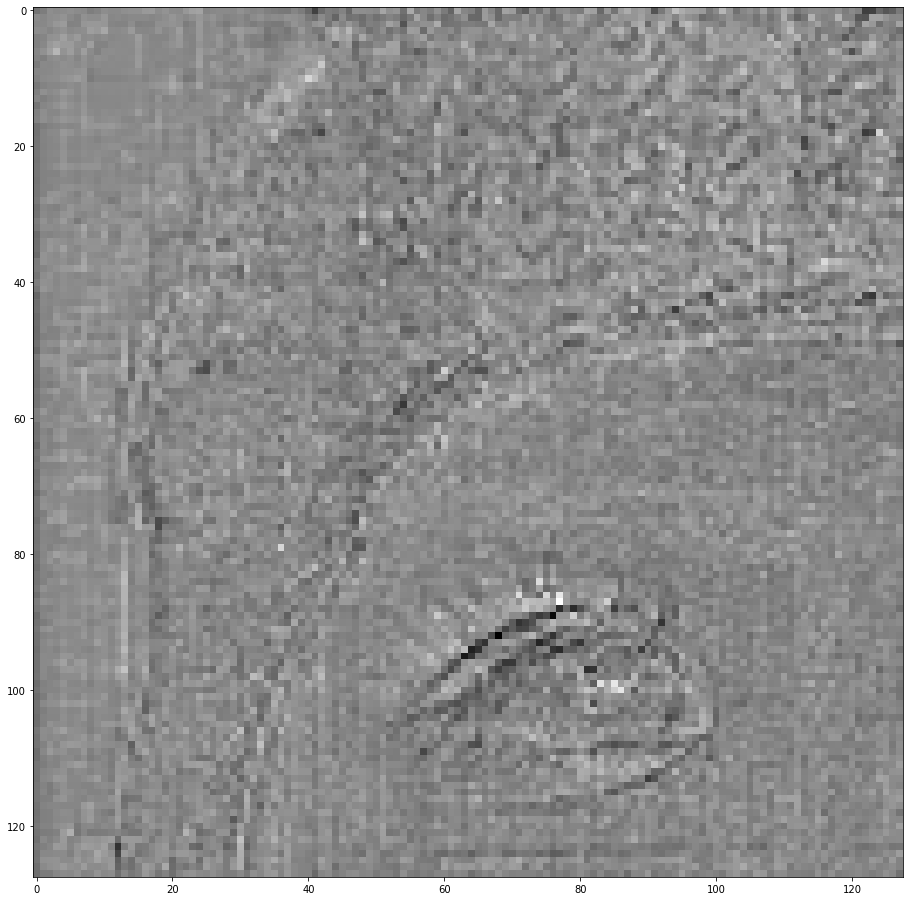

In [11]:
# Visualize feature maps. - encoded map 1~n
# fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for encoded_map in encoded:
    # maps = encoded_map[0].permute(2,0,1).cpu().numpy()

    # for i in range(16):
    #     axs[i//4, i%4].imshow(maps[i], cmap='gray')
        
    plt.figure(figsize=(16,16))
    plt.imshow(encoded_map[0, :128, :128, 2].cpu().numpy(), cmap='gray')
    plt.show()

In [12]:
# Show feature maps after a single attention layer (with out MLP layer).
with torch.no_grad():
    x = model.block_norm_layers[-1](encoded[-2])
    block = getattr(model, 'block_{}'.format(model.n_block))
    layer = block.encoder_layers[0]

    _, H, W, _ = x.shape
    mask = block.get_masks(H, W, x.device)
    res = layer.attention_layer(layer.norm_layers[0](x), mask=mask)
    x = x + res

    y = layer.feed_forward_layer(layer.norm_layers[1](x))

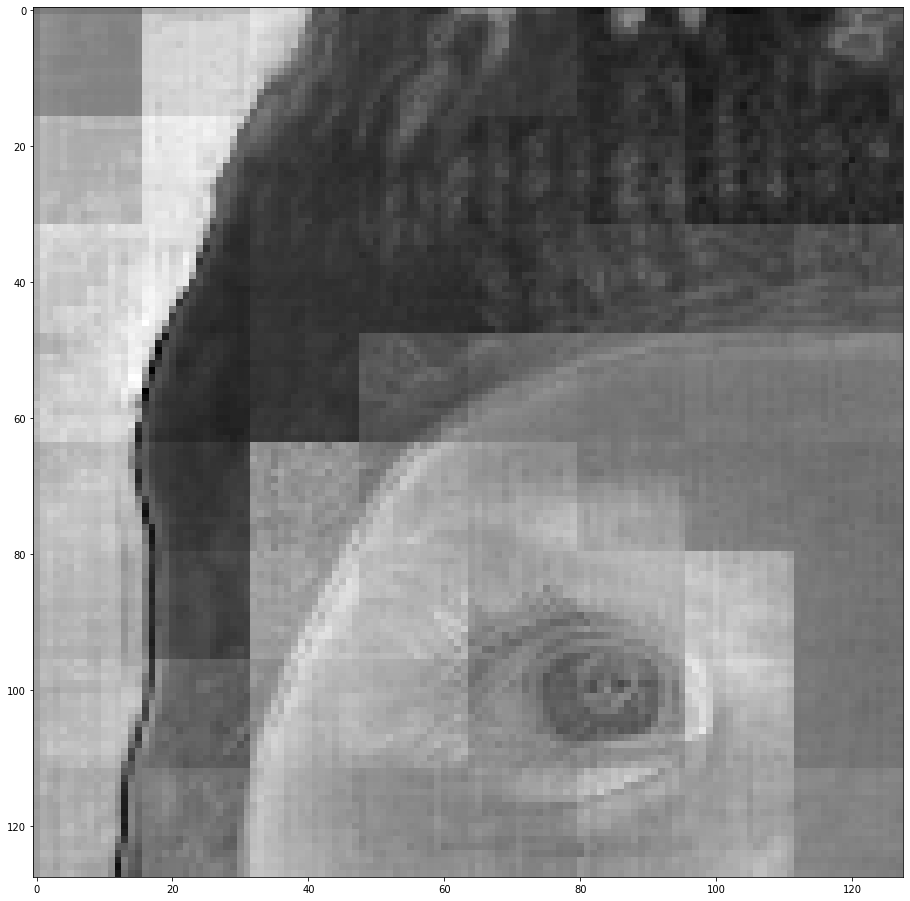

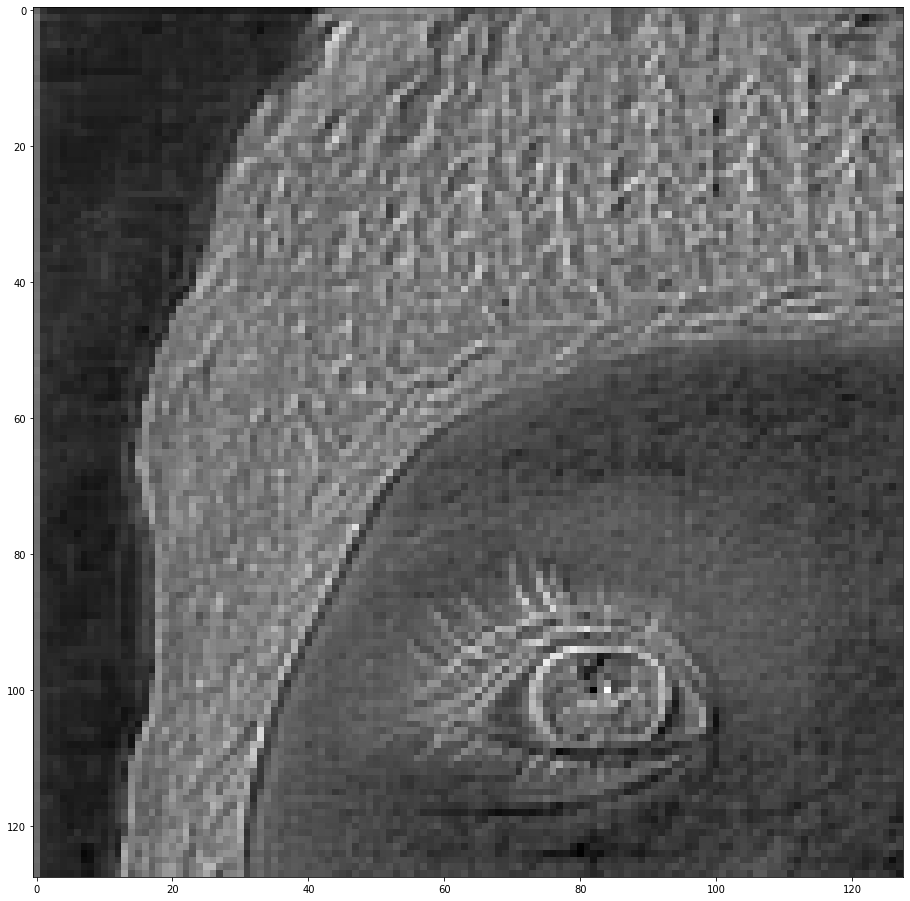

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(res[0, :128, :128, 2].cpu().numpy(), cmap='gray')
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(y[0, :128, :128, 2].cpu().numpy(), cmap='gray')
plt.show()

In [3]:
with torch.no_grad():
    key_bias_current = model.block_1.encoder_layers[-1].attention_layer.key_conv_layer.bias.cpu().numpy()
    query_bias_current = model.block_1.encoder_layers[-1].attention_layer.query_fc_layer.bias.cpu().numpy()

    model.load_state_dict(torch.load('logs/X2/20230730_221828/state_dict/state_dict_step_2000.pt', map_location='cpu'))
    key_bias_initial = model.block_1.encoder_layers[-1].attention_layer.key_conv_layer.bias.cpu().numpy()
    query_bias_initial = model.block_1.encoder_layers[-1].attention_layer.query_fc_layer.bias.cpu().numpy()

In [4]:
# Current
print('query')
print(query_bias_current[:10])

print('key')
print(key_bias_current[:10])

print('value')
print(key_bias_current[-10:])

query
[ 0.01494407  0.0937088   0.01339763 -0.00925962  0.03342576  0.04704095
  0.03333679  0.01585911 -0.00738849  0.01212534]
key
[ 1.21945130e-04 -2.63098947e-04  3.42146377e-05  7.56108639e-05
 -1.21744830e-04 -2.33544546e-04 -1.57532646e-04 -1.16597614e-04
 -1.41386074e-04 -7.65753866e-05]
value
[ 0.002596    0.0098236   0.00802496  0.00417468 -0.0051633   0.01203776
 -0.00543289 -0.02103256  0.01668451  0.00407475]


In [5]:
# Initial
print('query')
print(query_bias_initial[:10])

print('key')
print(key_bias_initial[:10])

print('value')
print(key_bias_initial[-10:])

query
[ 1.0352354e-03  7.6129904e-04  1.1428167e-03  5.8238104e-04
 -5.7219510e-04 -9.6044067e-04 -4.1081806e-04 -2.8160930e-04
 -6.3610736e-05 -7.1287768e-06]
key
[-1.3748094e-08 -2.0863844e-08 -1.4550949e-08 -5.1896856e-09
  1.5346556e-08  3.2600862e-08  2.2796527e-08 -6.7399846e-09
 -1.0041764e-08 -7.0047128e-09]
value
[ 0.00047271  0.00195124  0.00153402  0.00346958 -0.00120637  0.0001059
  0.00500163  0.0010181   0.00021789 -0.00010475]


In [6]:
# Difference
print('query')
print(((query_bias_initial - query_bias_current) ** 2).sum())

print('key')
print(((key_bias_initial[:288] - key_bias_current[:288]) ** 2).sum())

print('value')
print(((key_bias_initial[-288:] - key_bias_current[-288:]) ** 2).sum())

query
0.57515556
key
1.9757012e-05
value
0.08940703
